# VGG-16 with Data Augmentation

We now try using the famous VGG16 CNN network published by the University of Oxford, UK. We will use a technique called *"Transfer Learning"* to borrow the pre-trained weights of the CNN layers of the VGG network for classification in our problem. In doing so, we will create a CNN model with layers and weights copied from the VGG16, and then adjust the output of the layers so that it will output the number of classes (dataset A or B). 

We should note that the input shape of the VGG16 is a **244x244x3** color image. But our data size is much smaller, say 40(H)x60(W) in one channel. We can't simply reshape the input shape of the VGG16 network because of the dimensionality reduction of the layers deep in the network. 

To deal with this, we can resize the input shape of VGG16 input to match the size of the dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import time

from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout, Input, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
file_A = 'class_a.npy'
file_B = 'class_b.npy'
file_field = 'field.npy'

In [3]:
class_A = np.load(file_A)
class_B = np.load(file_B)
field = np.load(file_field)

In [4]:
print(class_A.shape)
print(class_B.shape)
print(field.shape)

(1000, 40, 60)
(1000, 40, 60)
(200, 40, 60)


Get maximum and minimum value of each image data. The value lies between 0.0 and 1.0, which is welcome by neural network. Hence, no need to further rescale the value of the pixels.

In [5]:
print(np.max(class_A), np.min(class_A))

1.0 0.0


Obtain size and shape of the dataset and calculate the offset values for zero-padding.

In [6]:
num, height, width = class_A.shape
print(num, height, width)

INPUT_SIZE = 100
x1 = 20
x2 = 80
y1 = 30
y2 = 70

1000 40 60


Create a numpy array for enlarging the size of the image from (40,60,1) to (100, 100, 3). 
Copy each image 3 times and combine the copies into 3 channels.
The extra pixels are filled by zeros.

In [7]:
# resize the image set A & B to square by padding zeros, then form a 3-channel numpy array.
class_A_SQ = np.zeros((num, INPUT_SIZE, INPUT_SIZE, 3))
class_A_SQ[:,y1:y2,x1:x2,0] = class_A
class_A_SQ[:,y1:y2,x1:x2,1] = class_A
class_A_SQ[:,y1:y2,x1:x2,2] = class_A

class_B_SQ = np.zeros((num, INPUT_SIZE, INPUT_SIZE, 3))
class_B_SQ[:,y1:y2,x1:x2,0] = class_B
class_B_SQ[:,y1:y2,x1:x2,1] = class_B
class_B_SQ[:,y1:y2,x1:x2,2] = class_B

Print out some samples of the newly created dataset.

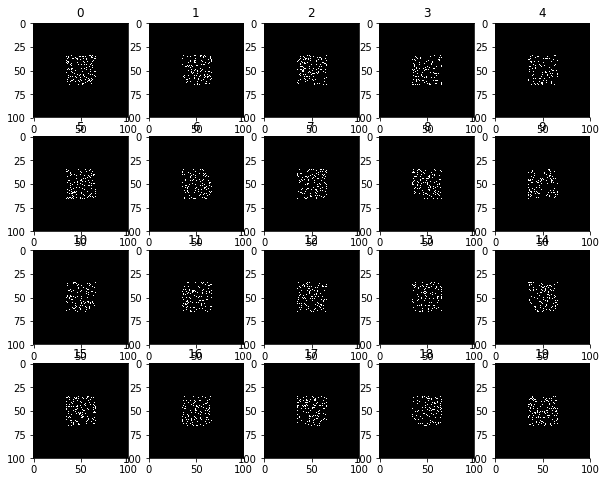

In [8]:
plt.rcParams['figure.figsize'] = (10.0,8.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title(i)
    plt.imshow(class_B_SQ[i])

Combine the dataset A and B into one and the respective labels.

In [9]:
train_img = np.concatenate((class_A_SQ, class_B_SQ), axis=0)
train_label = np.zeros(num*2)
train_label[num:] = 1

In [10]:
print(train_img.shape)

(2000, 100, 100, 3)


In [11]:
print(train_label.shape)

(2000,)


Reshuffle randomly the dataset and the respective labels.

In [12]:
# shuffle the image data and the respective labels randomly
np.random.seed(1234)

indices = np.random.permutation(train_img.shape[0])
train_img = train_img[indices]
train_label = train_label[indices]

Let's review the shuffled samples one more time.

[1. 0. 1. ... 1. 0. 0.]


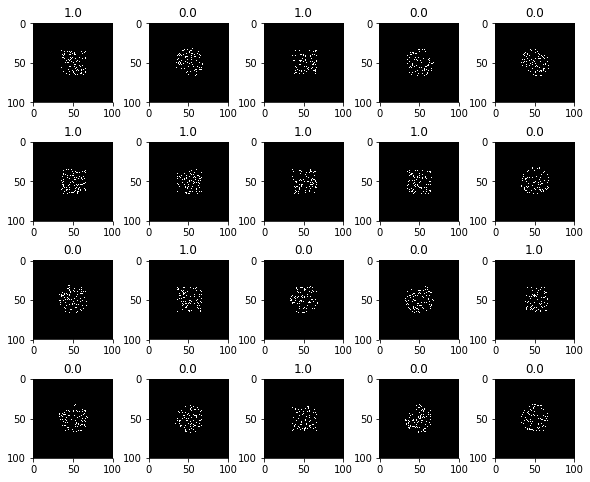

In [13]:
plt.rcParams['figure.figsize'] = (10.0,8.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title(train_label[i])
    plt.imshow(train_img[i])
    plt.subplots_adjust(hspace=0.5)
print(train_label)

Next, perform one-hot encoding to the labels of the training set, i.e. 0 = '01', 1 = '10'.

In [14]:
from keras.utils import np_utils
# perform one-hot encoding to the train labels
train_label = np_utils.to_categorical(train_label)

In [15]:
print(train_label)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


Next, split 80% of the dataset into train set and the remaining 20% into validation set for training.

In [16]:
train_num = int(train_img.shape[0] * 0.8)

# split train and evaluation sets
x_Train = train_img[:train_num]
y_Train = train_label[:train_num]

x_Eval = train_img[train_num:]
y_Eval = train_label[train_num:]

In [17]:
print(x_Train.shape)
print(y_Train.shape)
print(x_Eval.shape)
print(y_Eval.shape)

(1600, 100, 100, 3)
(1600, 2)
(400, 100, 100, 3)
(400, 2)


We can begin to construct the CNN network. Here are some constants and hyperparameters used in the network.

In [35]:
IMAGE_SIZE    = (INPUT_SIZE, INPUT_SIZE)
NUM_CLASSES   = 2
BATCH_SIZE    = 128  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 1e-4
WEIGHTS_FINAL = 'model_vgg.h5'

In [20]:
# create helper function
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train], color="orange")
    plt.plot(train_history.history[validation], color="blue")
    plt.title('Train History')
    plt.xlabel('Epochs')
    plt.ylabel(train)
    plt.show()

Create the VGG16 network and download the pre-trained weights using Keras. The first input layer is reshaped and the layers are frozen for training, with the exception of the final 4 layers. This can preserved the weights which have been trained on the vast quantity of objects and are helpful in the classification.

In [36]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)
    
vgg_conv.summary()

<keras.engine.input_layer.InputLayer object at 0x7f64e24e6c88> False
<keras.layers.convolutional.Conv2D object at 0x7f64e24e6978> False
<keras.layers.convolutional.Conv2D object at 0x7f64e24e69b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f64e1406cc0> False
<keras.layers.convolutional.Conv2D object at 0x7f64e24fd048> False
<keras.layers.convolutional.Conv2D object at 0x7f64e24a70f0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f64e14a9390> False
<keras.layers.convolutional.Conv2D object at 0x7f64e24bc198> False
<keras.layers.convolutional.Conv2D object at 0x7f64e244aac8> False
<keras.layers.convolutional.Conv2D object at 0x7f64e24629e8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f64e2472a20> False
<keras.layers.convolutional.Conv2D object at 0x7f64e2408668> False
<keras.layers.convolutional.Conv2D object at 0x7f64e242f240> False
<keras.layers.convolutional.Conv2D object at 0x7f64e23da588> False
<keras.layers.pooling.MaxPooling2D object at 0x7f64e2387550>

Create the layers for outpuit and classification.

In [37]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=LEARNING_RATE), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 1026      
Total params: 17,075,522
Trainable params: 9,440,258
Non-trainable params: 7,635,264
_________________________________________________________________


Since the dataset has only 1000 for each class, we employ the "Image Augmentation" to create more image dataset based on the existing data. To do so, we can use the ImageDataGenerator provided by Keras.

In [38]:
train_datagen = ImageDataGenerator(#featurewise_center=True, 
                             rotation_range=5,
                             zoom_range=0.2,
                             #shear_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)

valid_datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)

In [39]:
#model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['accuracy'])

start_time = time.time()
#train_history = model.fit(x_Train, y_Train, epochs=40, batch_size=128, validation_data=(x_Eval, y_Eval))

train_history = model.fit_generator(train_datagen.flow(x_Train, y_Train, batch_size=BATCH_SIZE),
                                    #validation_data = (x_Eval, y_Eval),
                                    validation_data = valid_datagen.flow(x_Eval, y_Eval, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(x_Train) / BATCH_SIZE, epochs=NUM_EPOCHS)


end_time = time.time()

Epoch 1/40
13/12 [===============================] - 83s 6s/step - loss: 0.8841 - acc: 0.6347 - val_loss: 0.3037 - val_acc: 0.9675
Epoch 2/40
13/12 [===============================] - 81s 6s/step - loss: 0.3419 - acc: 0.8556 - val_loss: 0.0971 - val_acc: 0.9750
Epoch 3/40
13/12 [===============================] - 83s 6s/step - loss: 0.2875 - acc: 0.8766 - val_loss: 0.2524 - val_acc: 0.9900
Epoch 4/40
13/12 [===============================] - 83s 6s/step - loss: 0.1427 - acc: 0.9561 - val_loss: 0.4765 - val_acc: 0.8000
Epoch 5/40
13/12 [===============================] - 85s 7s/step - loss: 0.0833 - acc: 0.9729 - val_loss: 0.0750 - val_acc: 0.9700
Epoch 6/40
13/12 [===============================] - 84s 6s/step - loss: 0.1538 - acc: 0.9464 - val_loss: 0.0180 - val_acc: 1.0000
Epoch 7/40
13/12 [===============================] - 82s 6s/step - loss: 0.1864 - acc: 0.9361 - val_loss: 0.0152 - val_acc: 0.9950
Epoch 8/40
13/12 [===============================] - 82s 6s/step - loss: 0.1232 - a

In [40]:
print("Total time taken for training: {:.2f}sec run on a GPU 1080".format((end_time - start_time)))

Total time taken for training: 3293.42sec run on a GPU 1080


After the training, we can evaluate the accuracy and plot the accuracy graph for training and evaluation dataset. We can see the performance of the model plateaus after 10th epochs.

In [41]:
score = model.evaluate(x_Eval, y_Eval, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0013178924289604765
Test accuracy: 1.0


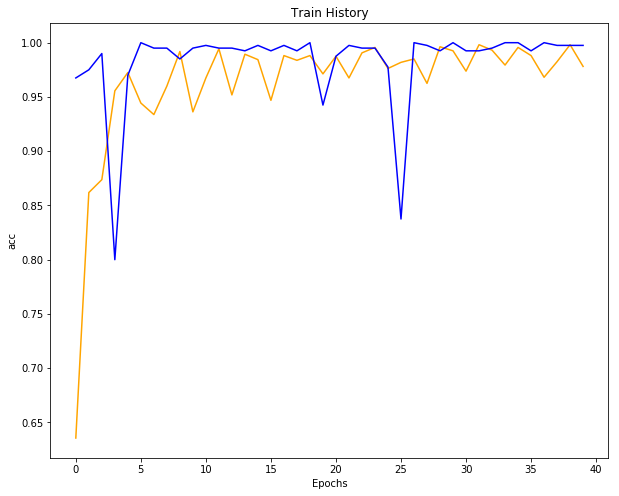

In [42]:
show_train_history(train_history, 'acc', 'val_acc')

Finally, to use the trained model for classification, we have to reshape and zero-pad the field dataset in the same manner as the train datasets.

In [43]:
# resize the image set A & B to square by padding zeros, then form a 3-channel numpy array.
field_SQ = np.zeros((field.shape[0], INPUT_SIZE, INPUT_SIZE, 3))
field_SQ[:,y1:y2,x1:x2,0] = field
field_SQ[:,y1:y2,x1:x2,1] = field
field_SQ[:,y1:y2,x1:x2,2] = field

In [44]:
# examine the new dataset shape
field_SQ.shape

(200, 100, 100, 3)

Feed the dataset into the model and run predictions. And plot the result for verification.

In [45]:
predictions = model.predict(field_SQ)
predictions = np.argmax(predictions, axis=1)

In [46]:
print(predictions)

[1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0
 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1
 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0
 1 1 0 0 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0
 1 0 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1
 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0]


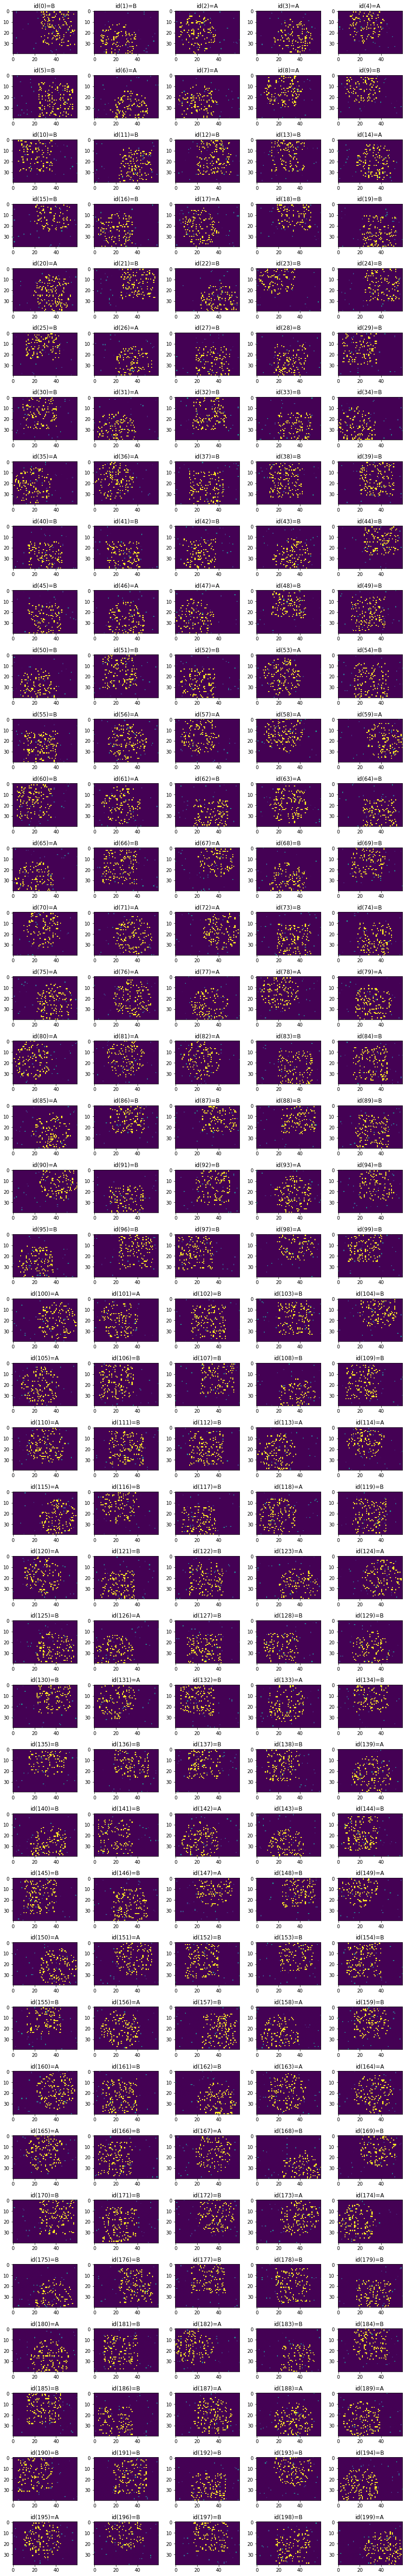

In [47]:
plt.rcParams['figure.figsize'] = (15.0,100.0)
for i in range(200):
    plt.subplot(40,5,i+1)
    if int(predictions[i]) == 1:
        ans = "B"
    else:
        ans = "A"
    plt.title("id("+str(i)+")="+ans)
    plt.imshow(field[i])
    plt.subplots_adjust(hspace=0.5)

We can output the model weights for future use.

In [48]:
model.save('model_data_vgg16.h5')

# Comparison of Models

It's time to compare the result of the 3 CNN models we have trained using the field dataset. However, we don't have the answers of the field dataset. Luckily, there are only 200 images in the field dataset and we can manually classify them on our own. Although we may label some samples in the field dataset incorrectly, we can still established a coarse reference level for comparing the models.

This is the labels we do for the field dataset. 0 denotes class A and 1 denotes class B. We store the result into numpy array `field_ans`

In [50]:
# labels we do for the field dataset.
field_ans = np.array([
    1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
    1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
    0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
    1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
    1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
    0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
    1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
    0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
    0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
    0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
    0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
    0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
    0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
    1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
    0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
    0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
    0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
    1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
    0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
    1, 1, 1, 0, 0, 0, 0, 1, 1, 0
])

In [51]:
from keras.models import load_model

test_data = np.expand_dims(field, axis = -1)
print(test_data.shape)

(200, 40, 60, 1)


### Basic CNN model

In [53]:
# load model weights and classify field dataset
basic_model = load_model('model_basic.h5')

basic_ans = basic_model.predict(test_data)
basic_ans = np.argmax(basic_ans, axis=1)

print(basic_ans)

basic_acc = basic_ans - field_ans

print(basic_acc)

print("Basic CNN model accuracy = ",(200 - np.count_nonzero(basic_acc))/200)

[1 0 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0
 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1
 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1
 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1
 0 0 1 1 0 0 1 1 1 0 0 1 0 0 0]
[ 0  0  0  1  0  0  1  0  0  0 -1  0  0  0  0  0 -1  0  1  0  1  0  0  0
 -1 -1  1  0  1 -1 -1  0  1  0  0  0  0 -1 -1  0  0 -1 -1  1 -1  0  1  0
 -1 -1  0 -1 -1  0  0 -1  0  0  0  1 -1  0 -1  0  0  0 -1  0  1  0  0  1
  1  0  0  1  1  1  0  1  0  0  0  0  0  1  0  0 -1  0  0 -1  0  0 -1 -1
 -1 -1  1 -1  1  0  0 -1  0  0  0 -1  0 -1  0  0  0  0  0  1  0 -1  0  0
  0  0 -1  1  1  0  0 -1 -1  1  0  0  0  0  1  1  1 -1 -1  0  1 -1  0  1
 -1  0  0  1  0  0  1  1 -1  0 -1 -1  0  0  0  1  1  0  1  0  0  0 -1  0
  0  1 -1  0  1  1  0  1 -1  0  0  0  1 -1  0 -1  0 -1 -1  1  1  0 -1  0
  0  1  0

### Basic CNN model with Image Data Augmentation

In [55]:
datagen_model = load_model('model_data_gen.h5')

datagen_ans = datagen_model.predict(test_data)
datagen_ans = np.argmax(datagen_ans, axis=1)

print(datagen_ans)

data_acc = datagen_ans - field_ans

print(data_acc)

print("Basic CNN with Image Augmentation accuracy = ",(200 - np.count_nonzero(data_acc))/200)

[1 0 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1
 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0
 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0
 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1
 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0]
[ 0  0  0  1  0  0  1  0  0  1  0  0  0  0  0  1  0  0  1  0  0  1  1  1
  0  0  0  0  1  0  0  1  1  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  1  1  1  0  0
  0  0  0  1  0  0  0  1  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0 -1
  0  0  1  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0
  0  1  0  1  0  1  1  0  0  0  0  0  1  0  1  0  1  0  0  0  0  0  0  1
 -1  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  1  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
  0  1  0

### Modified VGG16 CNN with Image Data Augmentation

In [57]:
vgg_acc = predictions - field_ans

print(vgg_acc)

print("Basic CNN with Image Augmentation accuracy = ",(200 - np.count_nonzero(vgg_acc))/200)

[0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0]
Basic CNN with Image Augmentation accuracy =  0.805


## Result Discussion and Observation

We have compared the accuracy of the 3 models on the field dataset. Here is the summary:

+ Basic CNN *without* Data Augmentation: 53%
+ Basic CNN *with* Data Augmentation: 78%
+ VGG16 CNN *with* Data Augmentation: 81%

We have the following observation:
+ Our manually labelled answers to the field dataset for establishing the comparison of models above may not be accurate. It sometimes is hard to labelled some images because the dot pattern is not in the centre of the image and is shifted laterally. Some images even look incomplete. These may cause the reduction of accuracy of the models towards the field dataset.
+ 1000 image from each class of A and B for training is not sufficient for training a good model with a small scale CNN, as the differentiable features of datasets A and B are not quite noticeable (both comprise of dots and randomly scattered within a region) and obvious to the simple CNN;
+ More data is needed to boost the accuracy and data augmentation further raise the accuracy from 53% to 78% using the same CNN;
+ VGG16, a deeper and more complicated CNN, may not bring considerable performance boost as we originally thought. We intended to bring the learnt neural network weights of VGG16 towards the circular and squarly patterns as observed from the field dataset but the gain in accuracy is not noticeable. Overfitting occurs as well.
+ Due to the small image data dimension, the further the image data goes through the network in a forward pass, the smaller the dimension it becomes after each convolution and pooling layers. Although we have used the trick of zero-padding to enlarge the image dimension of the dataset for input to the VGG16, the amount of information of the dot patters in the input images, which the CNN has to learn, becomes lesser compared to the overall image size of 100x100.
+ To really unleash the power of VGG16 / other deeper CNN such as ResNet or Inception on the above problem, it is preferable to have the real photo (color or grayscale) taken from the field data, for having more information to be learnt by the CNN.